In [1]:
# 01 - Import Libraries
import torch
from torch import nn
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
import numpy as np
import PIL
from torch.utils.data import DataLoader
from timeit import default_timer as timer
from tqdm.auto import tqdm
RANDOM_SEED = torch.manual_seed(42)

In [2]:
# Necessary Functions
device = "cuda" if torch.cuda.is_available() else "cpu"
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_true)) * 100
    return acc

def train_timer(start:float, end:float, device: torch.device=None):
    total_time = end-start
    print(f"Device:{device}:{total_time:.2f}sec")
    return total_time

def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn):
    model.eval()
    total_loss, total_acc = 0, 0

    with torch.inference_mode():
        for img, labels in tqdm(data_loader):
            img, labels = img.to(device), labels.to(device)  
            preds = model(img)
            loss = loss_fn(preds, labels)
            acc = accuracy_fn(labels, preds.argmax(dim=1))

            total_loss += loss.item()
            total_acc += acc

    avg_loss = total_loss / len(data_loader)
    avg_acc = total_acc / len(data_loader)

    return {
        "model_name": model.__class__.__name__,
        "model_loss": avg_loss,
        "model_acc": avg_acc
    }

def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            sample = torch.unsqueeze(sample, dim=0).to(device) 

            pred_logit = model(sample)

            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 1, so can perform on dim=0)

            pred_probs.append(pred_prob.cpu())
            
    return torch.stack(pred_probs)


In [3]:
# 02 - Datasets
train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor(),
    target_transform= None,
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor(),
    target_transform= None,
)

# 03 - DataLoad
class_names = train_data.classes
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=32,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                              batch_size=32,
                              shuffle=False)
train_features_batch, train_labels_batch = next(iter(train_dataloader))


100%|██████████| 26.4M/26.4M [01:02<00:00, 426kB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 150kB/s]
100%|██████████| 4.42M/4.42M [00:09<00:00, 461kB/s]
100%|██████████| 5.15k/5.15k [00:00<?, ?B/s]


In [4]:
# 04 - CNN Model (TinyVGG)
class FashionMNISTModelV2(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3,
                      stride=1, 
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7, 
                      out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        # print(x.shape)
        x = self.block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x

torch.manual_seed(42)
model_2 = FashionMNISTModelV2(input_shape=1, 
    hidden_units=10, 
    output_shape=len(class_names)).to(device)
model_2

FashionMNISTModelV2(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [6]:
# Loading the model
MODEL_SAVE_PATH = "Models/model_2.pth"
model_2.eval()

with torch.inference_mode():
    model_2.load_state_dict(torch.load(MODEL_SAVE_PATH))

model_2



FashionMNISTModelV2(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [20]:
import random
random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)


pred_probs= make_predictions(model=model_2, 
                             data=test_samples)

pred_classes = pred_probs.argmax(dim=1)

print(f"Test sample image shape: {test_samples[0].shape}\nTest sample label: {test_labels[0]} ({class_names[test_labels[0]]})")
print(pred_probs[:2])
print(pred_classes), print(test_labels)

Test sample image shape: torch.Size([1, 28, 28])
Test sample label: 5 (Sandal)
tensor([[3.0515e-06, 1.3098e-07, 3.4763e-07, 2.0300e-06, 2.9460e-08, 9.9501e-01,
         9.8975e-06, 2.4140e-04, 3.0888e-04, 4.4261e-03],
        [2.1434e-02, 9.1340e-01, 5.9956e-05, 2.0738e-02, 1.2810e-02, 2.7207e-04,
         3.0715e-02, 5.5070e-05, 2.5257e-04, 2.6055e-04]])
tensor([5, 1, 7, 4, 3, 6, 4, 7, 1])
[5, 1, 7, 4, 3, 0, 4, 7, 1]


(None, None)

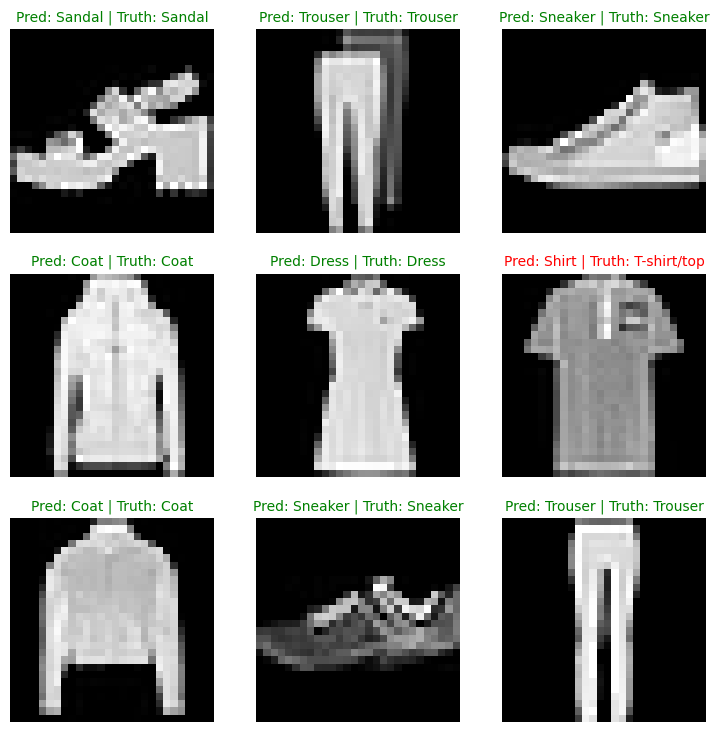

In [21]:
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  plt.subplot(nrows, ncols, i+1)
  plt.imshow(sample.squeeze(), cmap="gray")
  pred_label = class_names[pred_classes[i]]
  truth_label = class_names[test_labels[i]] 
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"
  if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g") 
  else:
      plt.title(title_text, fontsize=10, c="r") 
  plt.axis(False)